In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [19]:
df_es = pd.read_csv("../Data/historical_metering_data_ES.csv")
df_es.rename(columns={df_es.columns[0]: "DATETIME"}, inplace=True)
df_es['DATETIME'] = pd.to_datetime(df_es['DATETIME'])
df_es.set_index('DATETIME', inplace=True)
df_es["DATETIME"] = df_es.index

df_forecasts = pd.read_excel("../Data/spv_ec00_forecasts_es_it.xlsx")
df_forecasts.rename(columns={'Unnamed: 0': 'DATETIME'}, inplace=True)
df_forecasts['DATETIME'] = pd.to_datetime(df_forecasts['DATETIME'])
df_forecasts.set_index("DATETIME", inplace=True)

df_es = df_es.merge(df_forecasts[["spv", "temp"]], left_index=True, right_index=True, how="left")

holiday_df = pd.read_excel("../data/holiday_ES.xlsx")
holiday_dates = pd.to_datetime(holiday_df['holiday_ES']).dt.date
df_es['holiday'] = pd.Series(df_es.index.date, index=df_es.index).isin(holiday_dates).astype(int)
df_es['holiday'] = df_es['holiday'].astype(int)


# add features
df_es["hour"] = df_es["DATETIME"].dt.hour
df_es["month"] = df_es["DATETIME"].dt.month
df_es["dayofweek"] = df_es["DATETIME"].dt.dayofweek
df_es["is_weekend"] = (df_es["dayofweek"] >= 5).astype(int)


# Data from January 2022 - June 2024 is training data. Data for July is test data
cutoff = pd.to_datetime("2024-07-01")

cons_cols = [col for col in df_es.columns if col.startswith("VALUEMWHMETERINGDATA_")]


lagged_features = {
    f"{col}_lag24": df_es[col].shift(24)
    for col in cons_cols
}
lagged_features.update({
    f"{col}_lag168": df_es[col].shift(168)
    for col in cons_cols
})
df_lags = pd.DataFrame(lagged_features, index=df_es.index)
df_es = pd.concat([df_es, df_lags], axis=1)

feature_cols = ["hour", "month", "dayofweek", "is_weekend", "spv", "temp", "holiday"]


portfolio_pred = []
portfolio_true = []
results = []
for col in cons_cols:
    df_c = df_es[["DATETIME", col] + feature_cols + [f"{col}_lag24", f"{col}_lag168"]].copy()

    train_c = df_c[df_c["DATETIME"] < cutoff]
    test_c = df_c[df_c["DATETIME"] >= cutoff]


    X_train = train_c[feature_cols + [f"{col}_lag24", f"{col}_lag168"]]
    y_train = train_c[col]
    X_test = test_c[feature_cols + [f"{col}_lag24", f"{col}_lag168"]]
    y_test = test_c[col]
    valid_idx = y_train.notna() & np.isfinite(y_train)
    X_train = X_train[valid_idx]
    y_train = y_train[valid_idx]
    #evalset = [(X_train, y_train), (X_test,y_test)]
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    portfolio_pred.append(pd.Series(y_pred, index=test_c["DATETIME"]))
    portfolio_true.append(pd.Series(y_test.values, index=test_c["DATETIME"]))


In [20]:

portfolio_pred_df = pd.concat(portfolio_pred, axis=1)
portfolio_true_df = pd.concat(portfolio_true, axis=1)
target_customer = 0
mae = mean_absolute_error(
    portfolio_true_df.sum(axis=1),
    portfolio_pred_df.sum(axis=1)
)
mae

2.164430864346165

In [27]:
# custom scoring
w1 = 1
w2 = 2
pred_total = portfolio_pred_df.sum(axis=1)
true_total = portfolio_true_df.sum(axis=1)
abs_error = np.abs(pred_total - true_total).sum()
net_bias = np.abs(pred_total.sum() - true_total.sum())
custom_score = w1 * abs_error + w2 * net_bias

print(f"Custom Score = {custom_score:.2f}")
print(f" - Absolute error term: {abs_error:.2f}")
print(f" - Net portfolio bias term: {net_bias:.2f} (weighted x{w2})")

Custom Score = 3464.50
 - Absolute error term: 1610.34
 - Net portfolio bias term: 927.08 (weighted x2)


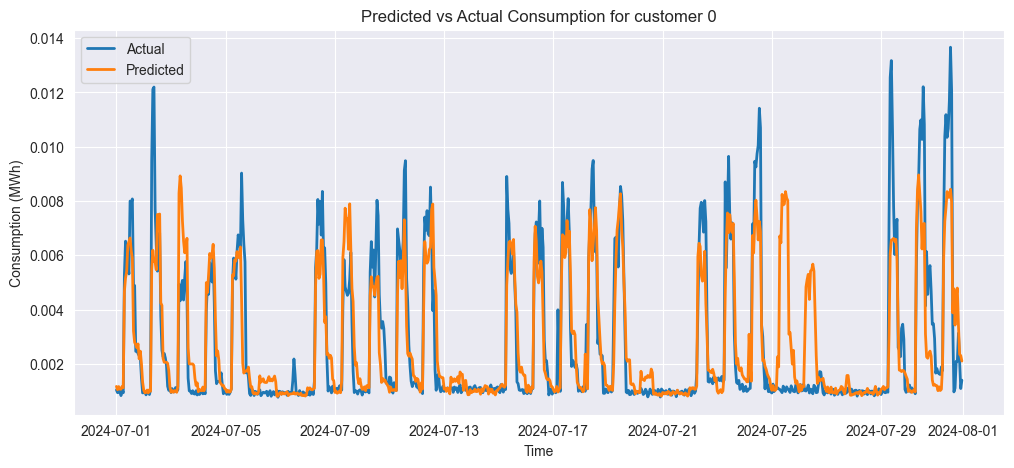

In [22]:
# Plot predicted vs actual for selected customer
plt.figure(figsize=(12, 5))
plt.plot(portfolio_true_df.index, portfolio_true_df[target_customer], label="Actual", linewidth=2)
plt.plot(portfolio_pred_df.index, portfolio_pred_df[target_customer], label="Predicted", linewidth=2)
plt.title(f"Predicted vs Actual Consumption for customer {target_customer}")
plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.legend()
plt.grid(True)
plt.show()